# Image classification

This project demonstrates how to identify flower photos. It uses a tf.keras.Sequential model to generate an image classifier and tf.keras.utils.image dataset from directory to load data. You'll get hands-on practise with the following concepts:

Loading a dataset from disc in a quick and efficient manner.
Detecting overfitting and using strategies like data augmentation and dropout to mitigate it.
A basic machine learning workflow is followed in this tutorial:

Analyze and comprehend data
Construct an input pipeline.
Create the model.
Educate the model
Validate the model.
Improve the model and go through the process again.

## Import TensorFlow and other libraries

## Explore the dataset by downloading it.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
Root = "/content/drive/MyDrive/Traffic_Dataset"
os.chdir(Root)

In [ ]:
dataset_dir = "/content/drive/MyDrive/Traffic_Dataset"
data_path = 'traffic_data'


In [ ]:
NUM_CATEGORIES = len(os.listdir(data_path))
NUM_CATEGORIES

7

The dataset contains seven sub-directories, one per class:

In [ ]:
import pathlib

data_dir = pathlib.Path(data_path)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


357


After downloading, you should now have a copy of the dataset available. There are 357 total images

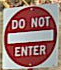

In [ ]:
Do_not_enter = list(data_dir.glob('Do Not Enter/*'))
PIL.Image.open(str(Do_not_enter[0]))

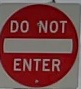

In [ ]:
PIL.Image.open(str(Do_not_enter[1]))

In [ ]:
Information = list(data_dir.glob('Information/*'))
PIL.Image.open(str(Information[0]))

In [ ]:
PIL.Image.open(str(Information[1]))

## Load data using a Keras utility

Let's use the tf.keras.utils.image dataset from directory utility to load these photos from disc. In just a few lines of code, you can go from a directory of photographs on disc to a tf.data.Dataset. You can alternatively visit the Load and preprocess pictures page to develop your own data loading code from scratch if you like.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

When constructing your model, it's a good idea to employ a validation split. Let's say we'll utilise 80% of the images for training and 20% for validation.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 357 files belonging to 7 classes.
Using 286 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 357 files belonging to 7 classes.
Using 71 files for validation.


You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Do Not Enter', 'Information', 'Left_Turn', 'Object Marker', 'School', 'Speed Limit', 'Stop']


## Visualize the data

Here are the first nine images from the training dataset:

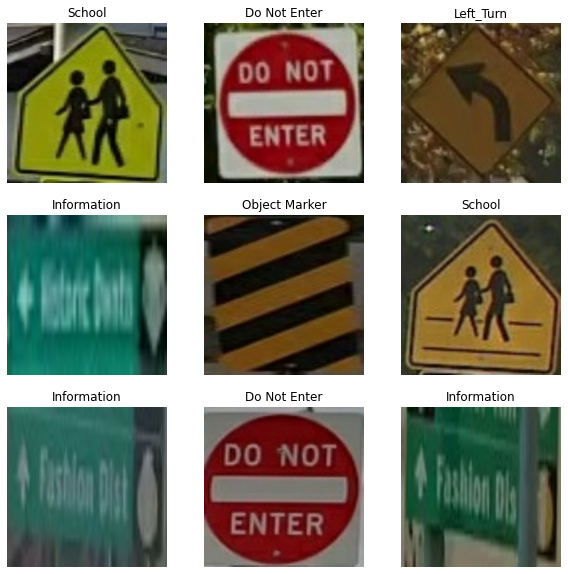

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In a moment, you'll feed these datasets to Model.fit to train a model with them. You may also manually traverse through the dataset and retrieve batches of photographs if you prefer:

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.

## Configure the dataset for performance

Let's make sure we're using buffered prefetching so we can get data from disc without I/O becoming blocked. When loading data, you should use the following two methods:

After the images are loaded from disc during the first epoch, Dataset.cache maintains them in memory. This will prevent the dataset from becoming a bottleneck during the training of your model. You can also use this method to establish a performant on-disk cache if your dataset is too huge to fit in memory.
During training, Dataset.prefetch combines data preprocessing and model execution.
In the Prefetching part of the Better performance with the tf.data API guide, interested readers can learn more about these methods, as well as how to cache data to disc.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling

In [ ]:
normalization_layer = layers.Rescaling(196,608)

There are two ways to use this layer. You can apply it to the dataset by calling Dataset.map

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

1279.2288 40967.594


# Create the model

Each of the three convolution blocks (tf.keras.layers.Conv2D) in the Sequential model has a max pooling layer (tf.keras.layers.MaxPooling2D). A ReLU activation function ('relu') activates a fully linked layer (tf.keras.layers.Dense) with 128 units on top of it. The purpose of this lesson is to demonstrate a standard approach, not to tune this model for high accuracy.

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(196,608, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

Choose tf.keras.optimizers for this lesson. tf.keras.losses and Adam optimizer Loss function for SparseCategoricalCrossentropy. Pass the metrics parameter to Model.compile to see training and validation accuracy for each training period.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's Model.summary method:

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)       

## Train the model

In [ ]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
9/9 [==============================] - 19s 2s/step - loss: 38377.9414 - accuracy: 0.2937 - val_loss: 1856.4507 - val_accuracy: 0.5915
Epoch 2/15
9/9 [==============================] - 18s 2s/step - loss: 1079.2747 - accuracy: 0.6678 - val_loss: 251.2314 - val_accuracy: 0.8310
Epoch 3/15
9/9 [==============================] - 18s 2s/step - loss: 143.0188 - accuracy: 0.8811 - val_loss: 17.6964 - val_accuracy: 0.9577
Epoch 4/15
9/9 [==============================] - 18s 2s/step - loss: 9.2170 - accuracy: 0.9860 - val_loss: 16.1062 - val_accuracy: 0.9718
Epoch 5/15
9/9 [==============================] - 19s 2s/step - loss: 2.4354 - accuracy: 0.9895 - val_loss: 26.1343 - val_accuracy: 0.9577
Epoch 6/15
9/9 [==============================] - 18s 2s/step - loss: 0.9970 - accuracy: 0.9965 - val_loss: 15.0365 - val_accuracy: 0.9577
Epoch 7/15
9/9 [==============================] - 18s 2s/step - loss: 0.3125 - accuracy: 0.9965 - val_loss: 16.0394 - val_accuracy: 0.9577
Epoch 8/15
9/9 

## Visualize training results

On the training and validation sets, plot the loss and accuracy:

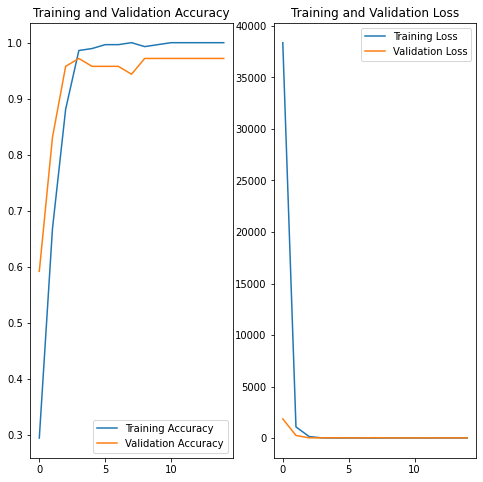

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are bit close to each other, and the model has achieved around 95% accuracy on the validation set. The training accuracy is increasing timely. 
In case of overfitting or less accuracy of validation, we can use data augmentation and droupout techniques to overcome the overfitting and better accuracy of validation data.

## Predict on new data

Finally, let's put our model to the test by classifying an image that wasn't in the training or validation sets.

In [ ]:

image_path="/content/drive/MyDrive/stop.jpg"
img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Left_Turn with a 100.00 percent confidence.


In [ ]:

image_path="/content/drive/MyDrive/object marker.jpg"



img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to School with a 100.00 percent confidence.
